In [1]:
import pandas as pd
import numpy as np
import glob
import os
import random
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import datetime
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, LSTM, Flatten, BatchNormalization, Dropout
from keras.utils import to_categorical
import tensorflow as tf
# Load the TensorBoard notebook extension
%load_ext tensorboard

Using TensorFlow backend.


In [2]:
countriesOfInterest = ["HK", "JP", 'ZA', 'TN', 'TR', 'GB', 'MX', 'US', 'CO', 'EC', 'AU', 'NZ']
train_n = 50
test_n = 10
Category = "Country"
w_length = 300
enc = OneHotEncoder()
enc.fit(np.array(countriesOfInterest).reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [3]:
def split(X, cat):
    X = X.reset_index()
    new_pos = list(X.track_id.index[X.track_id.shift(1) != X.track_id]) # indices where the song changes
    new_pos.append(max(X.track_id.index) + 1) # add a new index to know where the last song ends
    split_pos = []
    for i in range(len(new_pos)-1):
        split_pos = split_pos + list(range(new_pos[i], new_pos[i+1], w_length))
    split_pos = split_pos[1:]
    us_train = np.split(X.iloc[:,:24].to_numpy(), split_pos)
    labs = np.split(X[Category].to_numpy(), split_pos)
    # drop the short sequences
    short_seqs = []
    temp = [] 
    labels = []
    for i, value in enumerate(us_train):
        if value.shape[0] == w_length:
            temp.append(value)
            labels.append(labs[i][0])
    us_train = temp
    return np.stack(us_train), labels

In [4]:
def getSamples():
    train = pd.DataFrame()
    train_labels = pd.DataFrame()
    val = pd.DataFrame()
    val_labels = pd.DataFrame()
    for country in countriesOfInterest:
        holdTrain = pickle.load( open( "Raw Track Data\\" + country + "_train.p", "rb" ) )
        holdTrain = holdTrain.drop(["confidence", "start", 
                                    "duration", "loudness_start", 
                                    "loudness_max_time",
                                   "loudness_max"], axis = 1)
        holdVal = pickle.load( open( "Raw Track Data\\" + country + "_val.p", "rb" ) )
        holdVal = holdVal.drop(["confidence", "start", 
                                    "duration", "loudness_start", 
                                    "loudness_max_time",
                                   "loudness_max"], axis = 1)
        unique = holdTrain.track_id.unique()
        unique = np.random.choice(unique, size=train_n, replace=False)
        holdTrain = holdTrain[holdTrain.track_id.isin(unique)]
        unique = holdVal.track_id.unique()
        unique = np.random.choice(unique, size=test_n, replace=False)
        holdVal = holdVal[holdVal.track_id.isin(unique)]
        train = train.append(holdTrain)
        val = val.append(holdVal)

    train_x, train_labels = split(train, Category)
    val_x, val_labels = split(val, Category)
    class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(train_labels),
                                                     list(train_labels))
    train_labels = enc.transform(np.array(train_labels).reshape(-1,1)).toarray()
    val_labels = enc.transform(np.array(val_labels).reshape(-1,1)).toarray()
    return train_x, train_labels, val_x, val_labels, class_weights

In [5]:
train_x, train_labels, val_x, val_labels, class_weights = getSamples()

In [6]:
max(np.sum(val_labels, axis = 0))/sum(np.sum(val_labels, axis = 0))

0.12454212454212454

In [7]:
max(np.sum(train_labels, axis = 0))/sum(np.sum(train_labels, axis = 0))

0.11009174311926606

In [8]:
model = keras.Sequential()
model.add(LSTM(20, 
               input_shape=(train_x.shape[1], train_x.shape[2]), 
               return_sequences = True,
              recurrent_dropout = .25))
model.add(LSTM(40, 
               input_shape=(train_x.shape[1], train_x.shape[2]), 
               return_sequences = True,
              recurrent_dropout = .25))
model.add(LSTM(80, 
               input_shape=(train_x.shape[1], train_x.shape[2]), 
               return_sequences = False,
              recurrent_dropout = .25))
model.add(BatchNormalization())
model.add(Dense(100, activation= "relu"))
model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Dense(len(enc.categories_[0]), activation= "softmax"))
adam = keras.optimizers.Adam(lr=0.0001)
model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300, 20)           3600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 40)           9760      
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                38720     
_________________________________________________________________
batch_normalization (BatchNo (None, 80)                320       
_________________________________________________________________
dense (Dense)                (None, 100)               8100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

286/286 [==============================] - 1s 2ms/sample
[108. 123. 142. 124.  87. 121.  99. 115. 142. 118. 105. 160.]


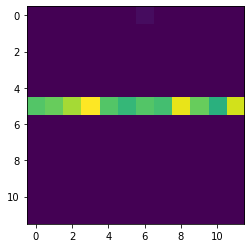

294/294 [==============================] - 0s 767us/sample
[117. 130. 143. 139.  91. 119. 111. 117. 147. 117. 105. 152.]


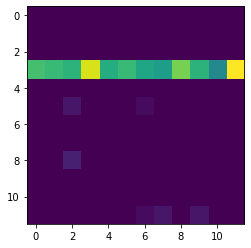

275/275 [==============================] - 0s 827us/sample
[102. 123. 141. 120.  90. 110.  98. 104. 142. 126. 109. 142.]


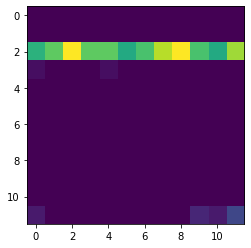

277/277 [==============================] - 0s 911us/sample
[102. 125. 131. 123.  89. 117. 107. 110. 143. 117.  95. 149.]


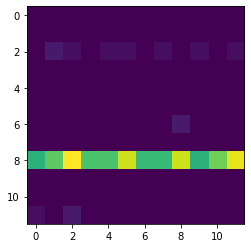

293/293 [==============================] - 0s 854us/sample
[108. 119. 145. 141.  87. 109. 104. 109. 141. 128.  92. 139.]


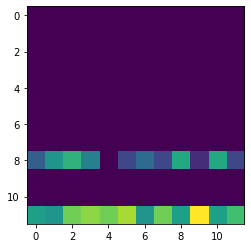

280/280 [==============================] - 0s 901us/sample
[102. 129. 138. 125.  80. 115.  97. 120. 147. 118. 119. 151.]


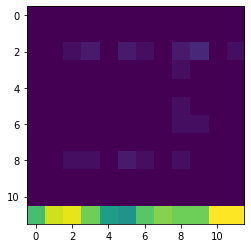

289/289 [==============================] - 0s 918us/sample
[107. 124. 131. 114.  72. 117.  95. 120. 146. 108. 118. 147.]


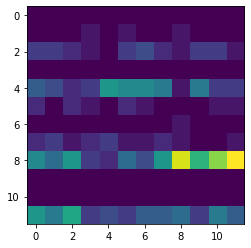

286/286 [==============================] - 0s 1ms/sample
[114. 124. 135. 151. 100. 108. 102. 119. 145. 118. 106. 150.]


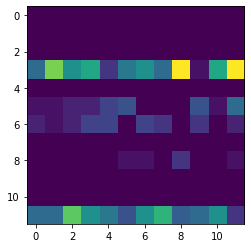

305/305 [==============================] - 0s 873us/sample
[ 99. 131. 144. 122.  91. 109.  90. 107. 144. 125. 113. 161.]


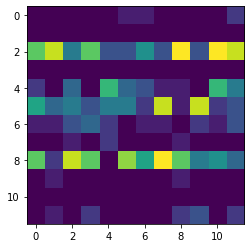

289/289 [==============================] - 0s 870us/sample
[ 96. 140. 134. 124.  94. 116.  89. 123. 144. 119. 109. 151.]


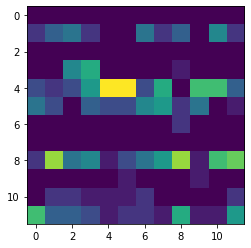

In [9]:
log_dir = os.path.join(
    "logs",
    "fit",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
epochs = 10
iterations = 100
for i in range(iterations):
    train_x, train_labels, val_x, val_labels, class_weights = getSamples()
    model.fit(train_x, train_labels,
              epochs = i * epochs + epochs, 
              initial_epoch = i * epochs,
              shuffle = True,
              validation_data = (val_x, val_labels),
              batch_size = 64,
              class_weight = class_weights,
             callbacks=[tensorboard_callback],
             verbose = 0)
    if i %10 == 0:
        preds = model.predict(val_x, batch_size = 256, verbose = 1)
        print(np.sum(train_labels, axis = 0))
        plt.imshow(
            confusion_matrix(
                enc.inverse_transform(preds), 
                enc.inverse_transform(val_labels), 
                normalize = "all"
            )
        )
        plt.pause(.5)
        plt.show()

284/284 [==============================] - 0s 910us/sample
[22.742065 21.284885 20.61895  20.484428 21.807816 24.263197 21.797266
 26.716639 22.331568 31.726381 24.905966 25.320805]
[27. 25. 27. 25. 16. 25. 21. 19. 28. 20. 24. 27.]


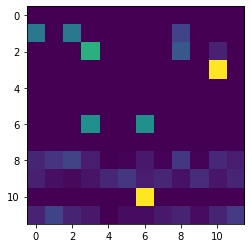

In [10]:
preds = model.predict(val_x, batch_size = 256, verbose = 1)
print(np.sum(preds, axis = 0))
print(np.sum(val_labels, axis = 0))
plt.imshow(
    confusion_matrix(
        enc.inverse_transform(preds), 
        enc.inverse_transform(val_labels), 
        normalize = "true"
    )
)

1438/1438 [==============================] - 1s 765us/sample
[112.821815 108.89403  111.283104 108.34256  107.09893  120.34332
 107.065186 132.3313   119.789696 156.74402  123.51506  129.77116 ]
[100. 125. 140. 140.  87. 118.  96. 118. 144. 117. 105. 148.]


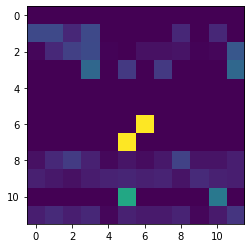

In [11]:
preds = model.predict(train_x, batch_size = 256, verbose = 1)
print(np.sum(preds, axis = 0))
print(np.sum(train_labels, axis = 0))
plt.imshow(
    confusion_matrix(
        enc.inverse_transform(preds), 
        enc.inverse_transform(train_labels), 
        normalize = "true"
    )
)

In [14]:
adam = keras.optimizers.Adam(lr=0.0001)
model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300, 20)           3600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 40)           9760      
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                38720     
_________________________________________________________________
batch_normalization (BatchNo (None, 80)                320       
_________________________________________________________________
dense (Dense)                (None, 100)               8100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

292/292 [==============================] - 1s 2ms/sample
[106. 118. 140. 134.  94. 104.  91. 113. 141. 120.  90. 148.]


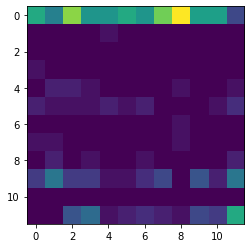

299/299 [==============================] - 0s 2ms/sample
[104. 130. 131. 118.  88. 112. 100. 106. 140. 111. 110. 171.]


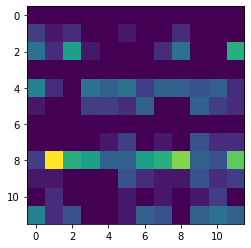

In [ ]:
log_dir = os.path.join(
    "logs",
    "fit",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
epochs = 10
iterations = 1000
for i in range(iterations):
    train_x, train_labels, val_x, val_labels, class_weights = getSamples()
    model.fit(train_x, train_labels,
              epochs = i * epochs + epochs, 
              initial_epoch = i * epochs,
              shuffle = True,
              validation_data = (val_x, val_labels),
              batch_size = 64,
              class_weight = class_weights,
             callbacks=[tensorboard_callback],
             verbose = 0)
    if i %10 == 0:
        preds = model.predict(val_x, batch_size = 256, verbose = 1)
        print(np.sum(train_labels, axis = 0))
        plt.imshow(
            confusion_matrix(
                enc.inverse_transform(preds), 
                enc.inverse_transform(val_labels), 
                normalize = "all"
            )
        )
        plt.pause(.5)
        plt.show()

In [ ]:
preds = model.predict(val_x, batch_size = 256, verbose = 1)
print(np.sum(preds, axis = 0))
print(np.sum(val_labels, axis = 0))
plt.imshow(
    confusion_matrix(
        enc.inverse_transform(preds), 
        enc.inverse_transform(val_labels), 
        normalize = "true"
    )
)

In [ ]:
preds = model.predict(train_x, batch_size = 256, verbose = 1)
print(np.sum(preds, axis = 0))
print(np.sum(train_labels, axis = 0))
plt.imshow(
    confusion_matrix(
        enc.inverse_transform(preds), 
        enc.inverse_transform(train_labels), 
        normalize = "true"
    )
)